Лисоченко Тимофей. t.lisoch16@gmail.com tg: @slugamonolitha

## NO-ML решение
____
Смотреть его. Нейросетевые решения приведены ниже, всего лишь, как попытка применить более продвинутые методы из NLP (GRU, Transformer) для данной задачи, как для задачи seq2seq

### Импорты и скачивание данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(['ggplot'])

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
import statsmodels as sts
import statistics

Загрузить данные можно из файлов в ропазитории  
https://github.com/T1mSan1ch/Card-transactions-prediction-ALFABANK/tree/main 

In [ ]:
test = pd.read_csv('df_test.csv', sep=';')
train = pd.read_csv('df_train.csv', sep=';')

Создадим копии датафремов где строки будут списками

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
df_train['Data'] = train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = test.Data.apply(lambda s: list(map(int, s.split(','))))

#### Асимптотическое среднее

In [ ]:
def asy_mean_test(mean_hat, std_hat, mu_0=0,
                   alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """

    z_obs = (mean_hat - mu_0)/std_hat

    # cdf - куммулятивная функция распределения
    # ppf - критическое значение
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2) # построение отступа, где альфа - ур. знач.

        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                        (z_crit, 0.05, z_crit, margin, 'b'),
                                        (-z_obs, -0.6, -margin, -z_obs, 'r'),
                                        (z_obs, 0.1, z_obs, margin, 'r')]))

    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))


    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]

    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]

        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin,
                 h*y_max, round(statistic, 2), color=color, fontsize=16)

        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)

    return p_value

### EDA и гипотезы

(0.0, 1000.0)

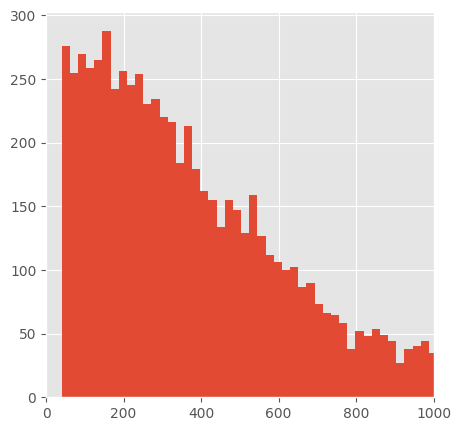

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
df_train.Data.apply(len).hist(figsize = (5,5), bins = 1000)
plt.xlim(right=1000)
plt.xlim(left=0)

In [ ]:
count_train_data = []
count_test_data = []

for client in df_train.Data:
  count_train_data.append(len(client))

for client in df_test.Data:
  count_test_data.append(len(client))

In [ ]:
count_test_data = np.array(count_test_data)
count_train_data = np.array(count_train_data)

Нормально ли распределение?

In [ ]:
shapiro_train = stats.shapiro(count_test_data)
shapiro_train

ShapiroResult(statistic=0.12388652563095093, pvalue=0.0)

- Нет. Тогда посмотрим на графики и убидимся в этом.

(0.0, 10000.0)

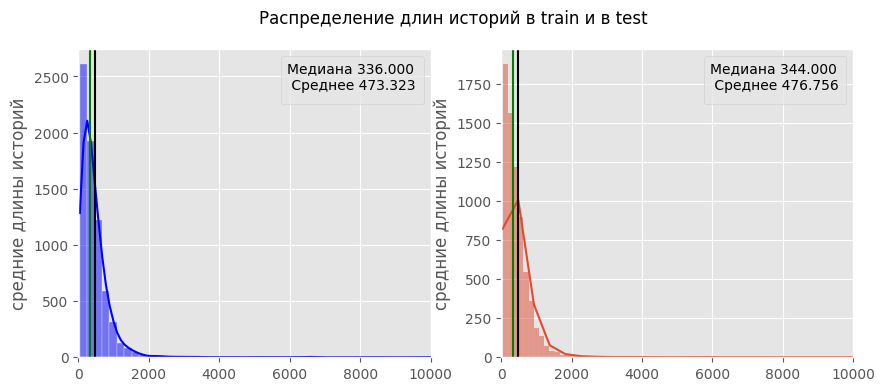

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=100)
sns.histplot(
    (count_train_data),
    ax=axes[0],
    bins=100,
    color = 'b' ,
    kde=True);
sns.histplot(
    (count_test_data),
    ax=axes[1],
    bins=600,
    kde=True);

fig.suptitle("Распределение длин историй в train и в test")

axes[0].legend(title="Медиана {:.3f} \n Среднее {:.3f}".format(
              (np.median(count_train_data)),
              (count_train_data.mean())),
              loc="upper right")
axes[0].axvline(np.median(count_train_data), color='g')
axes[0].axvline(count_train_data.mean(), color='black')
axes[0].set_ylabel("средние длины историй")
axes[0].set_xlim(0, 10000)

axes[1].legend(title="Медиана {:.3f} \n Среднее {:.3f}".format(
              (np.median(count_test_data)),
              (count_test_data.mean())),
              loc="upper right")
axes[1].axvline((np.median(count_test_data)), color='g')
axes[1].axvline((count_test_data.mean()), color='black')
axes[1].set_ylabel("средние длины историй")
axes[1].set_xlim(0, 10000)

Больше напоминает $\chi^2_{n}$. Воспользуемся тестом Калмогорова.

In [ ]:
stats.kstest(count_train_data, 'chi2', args=(count_train_data.mean(), count_train_data.std(ddof=1)))

KstestResult(statistic=0.9562916034388173, pvalue=0.0, statistic_location=1197, statistic_sign=1)

Но это не $\chi^2_{n}$, пускай это будет неизвестные распределение, но посмотреть на то, как они вглядят хочется. Применим преобразование Бокса-Кокса.

Text(0, 0.5, '$log(средней длины)$')

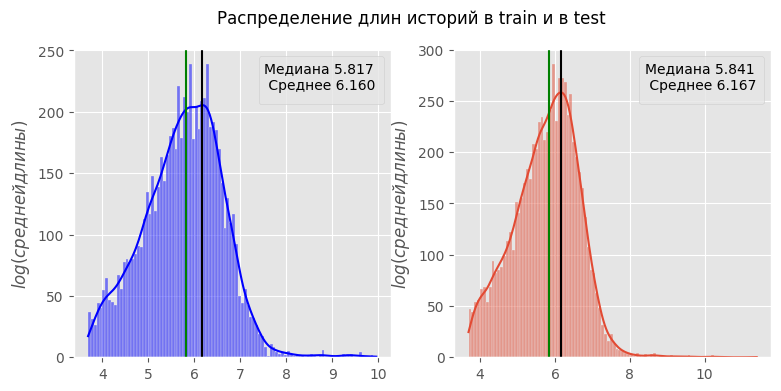

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), dpi=100)
sns.histplot(
    np.log(count_train_data),
    ax=axes[0],
    bins=100,
    color = 'b' ,
    kde=True);
sns.histplot(
    np.log(count_test_data),
    ax=axes[1],
    bins=100,
    kde=True);

fig.suptitle("Распределение длин историй в train и в test")

axes[0].legend(title="Медиана {:.3f} \n Среднее {:.3f}".format(
              np.log(np.median(count_train_data)),
              np.log(count_train_data.mean())),
              loc="upper right")
axes[0].axvline(np.log(np.median(count_train_data)), color='g')
axes[0].axvline(np.log(count_train_data.mean()), color='black')
axes[0].set_ylabel("$log(средней длины)$")

axes[1].legend(title="Медиана {:.3f} \n Среднее {:.3f}".format(
              np.log(np.median(count_test_data)),
              np.log(count_test_data.mean())),
              loc="upper right")
axes[1].axvline(np.log(np.median(count_test_data)), color='g')
axes[1].axvline(np.log(count_test_data.mean()), color='black')
axes[1].set_ylabel("$log(средней длины)$")

Графики выглядят похожими:
* Гипотеза: Данные из трейна и теста пришли из одного распределения. Воспользуемся тестом Калмогорова-Смирнова

$$
\begin{aligned}
H_0 : X_1 \sim X_2 \\
H_1 : X_1 \nsim X_2
\end{aligned}
$$

In [ ]:
stats.ks_2samp(count_train_data, count_test_data)

KstestResult(statistic=0.01635148585241007, pvalue=0.303985536729003, statistic_location=372, statistic_sign=1)

Видим, что $p\_value$ на порядок выше $5\%$, значит гипотеза не отвергается.

* Гипотеза: Средняя длина последовательности в train и test равны
Проверка гипотезы о равенстве средних. Выборки независимые. $alpha=5$

$$
\begin{aligned}
&H_0: \hspace{2mm} m_1 = m_2 \hspace{2mm} \text{Средние равны} \\
&H_1: \hspace{2mm} m_1 \ne m_2  \hspace{2mm} \text{Есть различия}
\end{aligned}
$$

In [ ]:
alpha = 0.05                                                                           # уровень значимости = 5%
nx, ny = count_train_data.size, count_test_data.size                                   # размер выборок

diff =  count_test_data.mean() -  count_train_data.mean()                              # разность средних
diff_std = np.sqrt(count_train_data.var(ddof=1)/nx + count_test_data.var(ddof=1)/ny)   # стандартное отклонение


0.4271677367964686

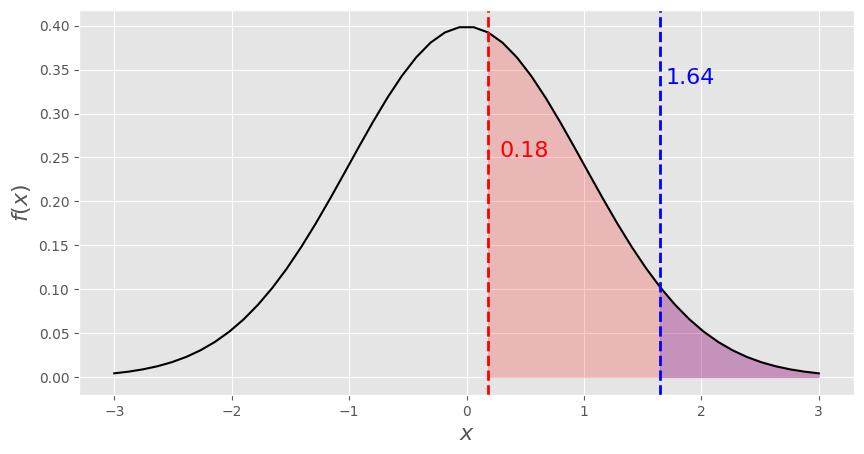

In [ ]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger')

Нулевая гипотеза не отвергается, средние заначения действительно близки.

In [ ]:
diff =  count_test_data.mean() -  count_train_data.mean()
diff

3.4332432816721052

Проверка гипотезы о равенстве средних и одинаковом распределении важны поскольку:

1.   Функция, которая выполняет роль предикта, создавалась с оглядкой на тестовые данные, так-как валидироваться можно было только на них.
2.   Одинаковое распределение гарантирует, что данные в выборках в среднем ведут себя схожим образом.
3.   Резюмируя предыдущие пункты, функция проводя манипуляции с данными из тестовой выборки, будет работать аналогичным образом и с тестовой выборкой.



#### Получим длины историй клиентов

In [ ]:
number_of_transactions = dict()

for i in range(0, 7033):
  number_of_transactions[i] = len(train.Data.iloc[i].split(','))

sorted_number_of_transactions = sorted(number_of_transactions.items(), key=lambda x: x[1], reverse=True)
sorted_number_of_transactions[:10] # 10 самых длинных историй

[(4210, 21101),
 (2451, 19177),
 (538, 18994),
 (1774, 15396),
 (807, 15196),
 (6699, 14734),
 (5370, 14504),
 (2122, 12327),
 (691, 12061),
 (3749, 12045)]

In [ ]:
sorted_number_of_transactions[-10:] # самых коротких историй

[(3420, 40),
 (4014, 40),
 (4679, 40),
 (4924, 40),
 (5068, 40),
 (5842, 40),
 (6035, 40),
 (6259, 40),
 (6422, 40),
 (7018, 40)]

### Функция, выполняющая роль предикта

__Ход написания функции предикта__


1.   `take_top10` - Самый базовый вариант решения. Просто берет топ 10 mcc кодов в истории. Даже не дойдя до предикта очевидно, что этоне оптимальное решение, тем не менее код я реализовал, это позволило мне от чего-то отталкиваться.
2.  Учитывать частотность эффективние, но в таком случае её нужно как-то считать. Для этого был написана функция `take_top_tail`, который проходится по истории и сначало считает количество для каждого mcc, потом происходит сортировка по count. Преобразуется в списки, поскольку кортежи неизменяемые, а я хочу учесть частоту. Для каждой пары [mcc, count] добавляется частотта встречаесмости.
3.  `weighted_10` - идея была округлить все вероятности, тогда все коды, которые ничего толком и незначат пропадут, а коды с вероятностью `0.08` или `0.19` округлятся ведь это почти `0.1` и `0.2` соответсвенно, логично было бы их округлить, а остальное откинуть
`for item in reversed(temp10):`
`if item[2] < 0.1:` `temp10.pop()`. Такое решение учитывает и крайние случаи и стандартные. По ходу разработки я проверил нет ли в тестовых и тренировочных данных таких клиентов, у которых есть только коды с вероятностью меньше 0.1 . Первый предикт был сделан на этом этапе - `map@10 = 0.255`.
4.  Посколько требуется предсказать 10 следующих, то необходимо подумать о неком тренде, который модет быть в данных. Для этого я решил увеличивать вес последних кодов из начально трети, а потом я добавил параметр, который позволяет регулировать вес - `weight_booster`, который предаётся кодам, и параметр, который у регулирует часть - `tail`, которой предаются больший вес.
5. Позже я решил добавить другой метод учета вероятности встречаемости кодов - `counted_10` в прочем результаты неудовлетворительны, поэтому он не используется.

In [ ]:
import random

def predict_next10_mcc(df : pd.DataFrame,
                      shuffled=False,
                      counted =False,
                      tail=0,
                      weight_booster=1):

  """
    Предсказывает 10 следующих транзакций клиента по его истории оппераций.
    Параметр `tail` и `weight_booster` позволяют учитывать тренд в данных.

    Parameters
    ----------
    df : pandas.DataFrame
        На вход принимает датафрейм, где в столбце `Data` содержатся истории
        клиентов в формате `str`
    counted : bool
        Использует метода `counted_10` в качестве предикта. Качество хуже
        Default is `False`
    shuffled : bool
        Используется вместе с `counted_10`. Перемешивает предикт этой функции,
        что в свою очередь повышает качество предикта
        Default is `False`
    tail : float **LESS THEN 1.0**
        tail определяет склько процентов mcc-кодов c конца истории клиента
        получат большей вес. Вес - кол-во конкретного mcc кода в истории клиента.
        Позволяет учесть тренд в данных.
    weight_booster : float or int
        Число на которое будет домнажаться количество кодов, которое встретилось
        в конце истории транзакций
        Default is `1`

    Returns
    -------
    predict : list
        Возвращает список, элементы которого содержат 10 mcc кодов разделенных
        запятой и пробелом.

  """

  def take_top_tail(df, tail=0, weight_booster=1):

    if tail > 1.0:
      raise ValueError("Число должно быть меньше или равно 1. Значения выше `0.444` понижают качество")

    weighted_top = []
    for row in df.Data:
      arr = row.split(",")
      sum_of_mcc = len(arr)
      row_top = dict()
      last33per = int(sum_of_mcc * tail)
      iter = 0
      for mcc in arr:
        iter +=1
        if iter < (sum_of_mcc - last33per):
          if mcc not in row_top:
            row_top[mcc] = 0
          row_top[mcc] += 1
        else:
          if mcc not in row_top:
            row_top[mcc] = 0
          row_top[mcc] += weight_booster

      sorted_count_mcc = (sorted(row_top.items(), key=lambda x: x[1], reverse=True))
      new_lst = [list(tup) for tup in sorted_count_mcc]
      for i in range(len(new_lst)):
        a = new_lst[i]
        new_lst[i] = [a[0], a[1], a[1]/ sum_of_mcc]
      weighted_top.append(new_lst)

    return weighted_top

  def take_10(row_top: list()):
    '''
    Получает строку, то есть список списков вида [[mcc, count, freq], [ , , ], ...].
    '''

    top10 = []
    if len(row_top) >= 10:
      for i in range(0, 10):
        top10.append(row_top[i][0])
      return top10
    else:
      while len(top10) < 10:
        for i in range(len(row_top)):
          top10.append(row_top[i][0])
      return top10[:10]

  def weighted_10(row_top: list()):
    """
    Получает строку, то есть список списков вида [[mcc, count, freq], [ , , ], ...].
    """

    top10 = []
    temp10 = row_top[:10]
    for i in range(len(temp10)):
      temp10[i][2] = round(temp10[i][2], 1)
    for item in reversed(temp10):
      if item[2] < 0.1:
        temp10.pop()
      else:
        break
    if len(temp10) == 10:
      for i in range(0, 10):
        top10.append(temp10[i][0])
      return top10
    else:
      sum_of_freq = 0
      while len(top10) < 10:
        for i in range(len(temp10)):
          sum_of_freq += (temp10[i][2])
          if temp10[i][2] >= 0.1:
            top10.append(temp10[i][0])
      return top10[:10]

  def counted_10(row_top: list(), shuffled):
    """
    Получает строку, то есть список списков вида [[mcc, count, freq], [ , , ], ...].
    """

    top10 = []
    temp10 = row_top[:10]
    for i in range(len(temp10)):
      temp10[i][2] = int(10 * round(temp10[i][2], 1)) + 1

    for i in range(0, len(temp10)):
      for _ in range(temp10[i][2]):
        top10.append(temp10[i][0])
    if shuffled:
      x = top10[:10]
      random.shuffle(x)
      return x
    else:
      return top10[:10]

  predict = []
  data_stats = take_top_tail(df, tail, weight_booster)
  if counted:
    for i in range(len(data_stats)):
      predict.append((counted_10(data_stats[i], shuffled=shuffled))) # ', '.join
  else:
    for i in range(len(data_stats)):
      predict.append((weighted_10(data_stats[i]))) # ', '.join

  return predict

### Метрика

In [ ]:
def apk(actual, predicted, k=10):
  """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

  """
  if len(predicted) > k:
      predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
      if p == actual[i]: # and p not in predicted[:i]
          num_hits += 1.0
          score += num_hits / (i+1.0)

  if not actual:
      return 0.0

  return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
  """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

### Predict
_____
0.28825 - predict_next10_mcc(test, counted=False,shuffled = False, tail=0.2, weight_booster=8)

In [ ]:
tails = [0.2, ]
weight_boosters = [ 8]

for tail in tails:
  for weight_booster in weight_boosters:

    score = mapk(df_train['Target'],
                  predict_next10_mcc(train,
                  counted=False,
                  tail=tail,
                  weight_booster=weight_booster,
                  ))
    print('Параметры: tail={}, weight_booster={}. score: {:.5f}'.format(
        tail,  weight_booster, score
    ))


Параметры: tail=0.2, weight_booster=8. score: 0.00000


In [ ]:
targ = df_train.Target.iloc[0]
targ0 = targ[0]
type(targ0)

int

In [ ]:
test['Predicted'] = predict_next10_mcc(test, counted=False,shuffled = False, tail=0.2, weight_booster=8)

In [ ]:
test.head(4)

,Id,Data,Predicted
0,0,"4814,4814,6011,6011,6010,6011,6011,4814,6011,4...","[6011, 4814, 4829, 6010, 5499, 5411, 5541, 601..."
1,1,"6010,6011,6010,5411,5411,5977,6011,6010,5411,6...","[6011, 4814, 6010, 5411, 5533, 4812, 5451, 601..."
2,2,"4814,6011,5251,6011,7832,5641,5814,4829,5311,6...","[6010, 6011, 4814, 5499, 5411, 4829, 5814, 601..."
3,3,"6011,4722,4722,4722,4814,6011,6011,4829,6011,6...","[6011, 4814, 5411, 5912, 5814, 4829, 5309, 596..."


In [ ]:
submission_baseline_2 = test[['Id', 'Predicted']]
submission_baseline_2['Predicted'] = submission_baseline_2.Predicted.astype(str).str.replace(',', '')
submission_baseline_2.to_csv('last_submission.csv', index=False)

## GRU и Transformer и отсуствующие вычислительные мощности
Параметры в моделях не оптимальные, т.к. обучение и настрока гиперпараметров  проходили на Kaggle поскольку там среда выполнения кода стабильние и видеопамяти чуть больше. Но даже из этих параметров видна разница в производительности моделей.

In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ALFABANK_CAMPUS/DATASETS/df_test.csv', sep=';')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ALFABANK_CAMPUS/DATASETS/df_train.csv', sep=';')

### Потготовка данных: токенезация, добавленеи паддингов, загрузка данных в DataLoader

In [ ]:
X = df_train['Data'].apply(lambda x: [int(i) for i in x.split(',')]).values
X_train, X_test = X[:5000], X[5000:]
y = df_train['Target'].apply(lambda x: [int(i) for i in x.split(',')]).values
y_train, y_test = y[:5000], y[5000:]

In [ ]:
code2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [X]:
    for sent in ds:
        for token in sent:
            if token not in code2word:
                code2word.append(token)

code2word = {token: idx for idx, token in enumerate(code2word)}
#code2word

In [ ]:
seq_length = 5000

In [ ]:
def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < max_length - 2: # -2 for SOS and EOS
        n_pads = max_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads
    else: # sent is longer than max_length; truncating
        encoded = [vocab[w] for w in sent]
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

In [ ]:
X_train_encoded = [encode_and_pad(code2word, sent, seq_length) for sent in X_train]
X_test_encoded = [encode_and_pad(code2word, sent, seq_length) for sent in X_test]
y_train_encoded = [encode_and_pad(code2word, sent, seq_length) for sent in y_train]
y_test_encoded = [encode_and_pad(code2word, sent, seq_length) for sent in y_test]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 128
train_x = np.array(X_train_encoded)
train_y = np.array(y_train_encoded)
test_x = np.array(X_test_encoded)
test_y = np.array(y_test_encoded)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
test_ds.tensors[0].shape

torch.Size([2033, 5000])

### Енкодер и Декодер

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)

        # GRU layer. The input and output are both of the same size
        #  since embedding size = hidden size in this example
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        # The inputs are first transformed into embeddings
        embedded = self.embedding(input)
        output = embedded

        # As in any RNN, the new input and the previous hidden states are fed
        #  into the model at each time step
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # This method is used to create the innitial hidden states for the encoder
        return torch.zeros(1, batch_size, self.hidden_size)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)

        # The GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size)

        # Fully-connected layer for scores
        self.out = nn.Linear(hidden_size, output_size)

        # Applying Softmax to the scores
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Feeding input through embedding layer
        output = self.embedding(input)

        # Applying an activation function (ReLu)
        output = F.relu(output)

        # Feeding input and previous hidden state
        output, hidden = self.gru(output, hidden)

        # Outputting scores from the final time-step
        output = self.softmax(self.out(output[0]))

        return output, hidden

    # We do not need an .initHidden() method for the decoder since the
    #  encoder output will act as input in the first decoder time-step

Получение длины словаря, и помещения Энкодера и Декодера на GPU

In [ ]:
unique_mcc_train = set()
for i in range(len(df_train)):
    items = df_train.loc[i, 'Data'].split(',')
    for item in items:
        unique_mcc_train.add(item)

unique_mcc_test = set()
for i in range(len(df_test)):
    items = df_test.loc[i, 'Data'].split(',')
    for item in items:
        unique_mcc_test.add(item)

len(unique_mcc_train) == len(unique_mcc_test), len(unique_mcc_train)

(True, 184)

In [ ]:
hidden_size = 128

encoder = EncoderRNN(len(unique_mcc_train)+3, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(unique_mcc_train)+3).to(device)

Loss - CrossEntropyLoss(). Именной такую функция используют для задачи seq2seq

In [ ]:
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 3e-3)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 3e-3)

### Обучение модели и получение предикта

In [ ]:
losses = []

In [ ]:
input_length = target_length = seq_length

SOS = code2word["<SOS>"]
EOS = code2word["<EOS>"]

epochs = 15

for epoch in range(epochs):
    for idx, batch in enumerate(train_dl):

        # Creating initial hidden states for the encoder
        encoder_hidden = encoder.initHidden()

        # Sending to device
        encoder_hidden = encoder_hidden.to(device)

        # Assigning the input and sending to device
        input_tensor = batch[0].to(device)

        # Assigning the output and sending to device
        target_tensor = batch[1].to(device)


        # Clearing gradients
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        with torch.set_grad_enabled(True):

            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            dec_result = torch.zeros(target_length, batch_size, len(code2word)).to(device)

            decoder_input = target_tensor[:, 0].unsqueeze(dim=0).to(device)

            decoder_hidden = encoder_hidden

            for i in range(1, target_length):

                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                best = decoder_output.argmax(1)

                decoder_input = best.unsqueeze(dim=0)


                dec_result[i] = decoder_output

            scores = dec_result.transpose(1, 0)[1:].reshape(-1, dec_result.shape[2])
            targets = target_tensor[1:].reshape(-1)

            loss = criterion(scores, targets)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            enc_optimizer.step()
            dec_optimizer.step()

            losses.append(loss.item())
            if idx % 16 == 0:
                print('Эпоха: {} , idx: {}, нормированный loss {}'.format(epoch ,idx, sum(losses)/len(losses)))

In [ ]:
plt.plot(losses)

In [ ]:
index2code = {}
for key, index in code2word.items():
    index2code[index] = key

In [ ]:
X_test_tensor = torch.tensor(X_test_encoded)
results= []
for sample in X_test_tensor:
    result = []
    encoder_hidden = torch.zeros(1, 1, hidden_size)
    encoder_hidden = encoder_hidden.to(device)

    input_tensor = sample.to(device).unsqueeze(dim=0)

    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()


    encoder_outputs = torch.zeros(seq_length, encoder.hidden_size, device=device)


    with torch.set_grad_enabled(False):
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        dec_result = torch.zeros(target_length, 1, len(code2word)).to(device)

        decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
        decoder_hidden = encoder_hidden
        for di in range(1, target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            best = decoder_output.argmax(1)
            result.append(index2code[best.to('cpu').item()])
            if best.item() == EOS:
                break

            decoder_input = best.unsqueeze(dim=0)
            dec_result[di] = decoder_output
        results.append(result)
        scores = dec_result.reshape(-1, dec_result.shape[2])
        targets = target_tensor.reshape(-1)

In [ ]:
results = [i[:-1] for i in results]

In [ ]:
mapk(results,list(y_test))

### Вывод о GRU

В результате обучения на пределе вычислительных возможностей и использовании оптимальных параметров максимальный скор по map@k достиг примерно 0.16..., что очевидно не достаточно. При визуальном просмотре предиктов, можно увидить, что порой модель предсказывала самый частый mcc-код в истории клиента.

Можно сделать вывод о том, что GRU не способна заглянуть так глубоко в историю клиента.

__Решение:__ попробовать трансформер

In [ ]:
import torchmetrics
import math

In [ ]:
X = df_train['Data'].apply(lambda x: [int(i) for i in x.split(',')]).values
X_train, X_val = X[:900], X[900:1200]
y = df_train['Target'].apply(lambda x: [int(i) for i in x.split(',')]).values
y_train, y_val = y[:900], y[900:1200]

In [ ]:
def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < max_length - 2: # -2 for SOS and EOS
        n_pads = max_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads
    else: # sent is longer than max_length; truncating
        encoded = [vocab[w] for w in sent]
        truncated = encoded[ : max_length -2]
        return sos + truncated + eos

In [ ]:
code2index = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [X]:
    for sent in ds:
        for token in sent:
            if token not in code2index:
                code2index.append(token)

code2index = {token: idx for idx, token in enumerate(code2index)}

In [ ]:
seq_length = 500

In [ ]:
X_train_encoded = [encode_and_pad(code2index, sent, seq_length) for sent in X_train]
X_val_encoded = [encode_and_pad(code2index, sent, seq_length) for sent in X_val]
y_train_encoded = [encode_and_pad(code2index, sent, 10) for sent in y_train]
y_val_encoded = [encode_and_pad(code2index, sent, 10) for sent in y_val]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 128
train_x = np.array(X_train_encoded)
train_y = np.array(y_train_encoded)
test_x = np.array(X_val_encoded)
test_y = np.array(y_val_encoded)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
val_dataloader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

### Transformer Model

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()

        self.dropout = nn.Dropout(dropout_p)

        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
       pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=500
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token = 0) -> torch.tensor:
      pad_token = 0
      # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
      # [False, False, False, True, True, True]
      return (matrix == pad_token)

### Train и Validation

In [ ]:
def train_loop(model, opt, loss_fn, dataloader):


    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[0].to(device), batch[1].to(device)
        #X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)"""
        """X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)"""

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [ ]:
def validation_loop(model, loss_fn, dataloader):
    """
    """

    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[0].to(device), batch[1].to(device)
        #X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
            '''X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)'''

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]

            y_expected = y[:,1:]

            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)


            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [ ]:
model = Transformer(
    num_tokens=187, dim_model=64, num_heads=8, num_encoder_layers=4, num_decoder_layers=4, dropout_p=0.1
).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0009)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    """

    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 30)

In [ ]:
def predict(model, input_sequence, max_length=10, SOS_token=1, EOS_token=2):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)


    num_tokens = len(input_sequence[0])


    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

In [ ]:
index2code = {v: k for k, v in code2index.items()}

In [ ]:
for i in range(400, 500):
  example = torch.tensor([X_train_encoded[i]], dtype=torch.long, device=device)
  result = predict(model, example)
  predict1 = []
  for j in result[1:]:
    predict1.append(index2code[j])
  print("predict1: {} target: {}".format(predict1, df_train.Target.iloc[i]))

Код из следующей статьи - попытка оптимизировать обучение с помощью [аккумуляцией градиентов по микробатчам](https://sebastianraschka.com/blog/2023/llm-grad-accumulation.html#what-is-gradient-accumulation). Поскольку [размер батча крайне важен](https://openreview.net/forum?id=B1Yy1BxCZ) в обучении трансформеров.


In [ ]:
def train(num_epochs, model, optimizer, train_loader, val_loader, fabric, accumulation_steps):

    for epoch in range(num_epochs):
        train_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=2).to(fabric.device)

        for batch_idx, batch in enumerate(train_loader):
            model.train()

            ### FORWARD AND BACK PROP
            outputs = model(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"]
            )

            outputs["loss"] = outputs["loss"] / accumulation_steps
            fabric.backward(outputs["loss"])

            ### UPDATE MODEL PARAMETERS
            if not batch_idx % accumulation_steps:
                optimizer.step()
                optimizer.zero_grad()

            ### LOGGING
            if not batch_idx % 300:
                print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} "
                      f"| Batch {batch_idx:04d}/{len(train_loader):04d} "
                      f"| Loss: {outputs['loss']:.4f}")

            model.eval()
            with torch.no_grad():
                predicted_labels = torch.argmax(outputs["logits"], 1)
                train_acc.update(predicted_labels, batch["label"])

        ### MORE LOGGING
        model.eval()
        with torch.no_grad():
            val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(fabric.device)
            for batch in val_loader:
                outputs = model(
                    batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["label"]
                )
                predicted_labels = torch.argmax(outputs["logits"], 1)
                val_acc.update(predicted_labels, batch["label"])

            print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} "
                  f"| Train acc.: {train_acc.compute()*100:.2f}% "
                  f"| Val acc.: {val_acc.compute()*100:.2f}%"
                  )
            train_acc.reset(), val_acc.reset()

### Вывод по трансформеру
Поиграв с гиперпараметрами я понял, что для обучения тарнсформера, требуетсся гараздо большие вычислительные мощности. Повышение размера батча, голов Multi-head self attention или слоёв энеодеров или декодеров - всё это требует видео памяти. В результате подель недообучена, и порой на выход подаёт последовательность длиной меньше 10, а про качестово и говорит нечего.